In [ ]:
import numpy as np
from numpy.random import Generator, PCG64
import matplotlib.pyplot as plt
import statistics as stat
import pandas as pd
import math

##**Gaussian noise with variance incrementing with time**
In the following work, we are going to add a gaussian noise in the parameter $\rho$ of the model, which is varying with time, as written below:

$\rho(t) = \rho_0 + 10^{-3}t + \eta(t)$
where $\eta(t) \sim \mathcal{N}(0,\sqrt{t})$.

The variance of the parameter is increasing with time.

In [ ]:
class LorenzDynamics:
  def __init__(self, sigma, beta, rho_0, rho_slope, noise_std):
    self.sigma = sigma
    self.beta = beta
    self.rho_0 = rho_0
    self.rho_slope = rho_slope
    self.noise_std = noise_std


  def rho(self,t):
    noise = np.random.normal(0,self.noise_std*math.sqrt(t))
    return self.rho_0 + self.rho_slope*t + noise

  def dynamics(self,state,t):
    x,y,z = state
    dxdt = self.sigma*(y-x)
    dydt = x*(self.rho(t)-z)-y
    dzdt = x*y-self.beta*z
    return np.array([dxdt,dydt,dzdt])

  def runge_kutta(self,state,t,dt):
    k1 = self.dynamics(state,t)
    k2 = self.dynamics(state+dt/2*k1,t+dt/2)
    k3 = self.dynamics(state+dt/2*k2,t+dt/2)
    k4 = self.dynamics(state+dt*k3,t+dt)
    new_state = state + dt/6*(k1+2*k2+2*k3+k4)
    return new_state

  def solve(self,IC,T,dt):
    t_values = np.arange(0,T,dt)
    states = np.zeros((len(t_values),len(IC)))
    states[0] = IC
    for i in range(1,len(t_values)):
      states[i] = self.runge_kutta(states[i-1],t_values[i-1],dt)
    return t_values,states

In [ ]:
T = 6000
dt = 0.005
IC = np.array([1.0,1.0,1.0])

sigma = 10.0
beta = 8.0/3.0
rho_0 = 26.0
rho_slope = 10**(-3)
noise_std = 1

lorenz = LorenzDynamics(sigma,beta,rho_0,rho_slope,noise_std)
t_values,states = lorenz.solve(IC,T,dt)

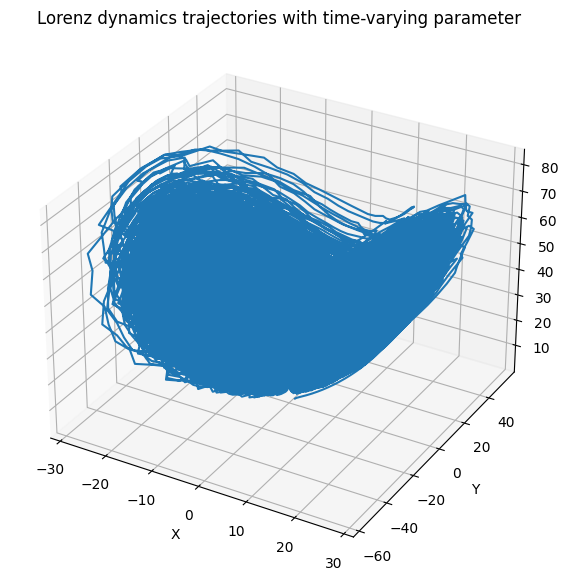

In [ ]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.plot(states[:, 0], states[:, 1], states[:, 2])
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Lorenz dynamics trajectories with time-varying parameter')
plt.show()

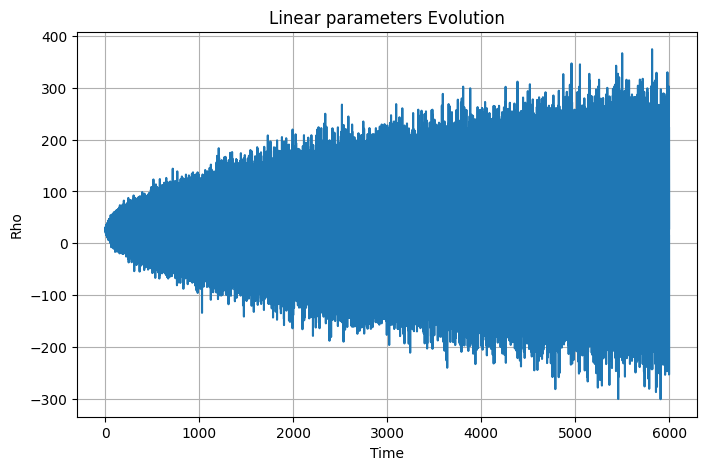

In [ ]:
# Linear time-varying rho parameter
rho_values = np.array([lorenz.rho(t) for t in t_values])
plt.figure(figsize=(8, 5))
plt.plot(t_values, rho_values)
plt.xlabel('Time')
plt.ylabel('Rho')
plt.title('Linear parameters Evolution')
plt.grid()
plt.show()

In [ ]:
x_values = states[:,0]
x_mean = stat.mean(x_values)
x_std = stat.stdev(x_values)
x_median = stat.median(x_values)

y_values = states[:,1]
y_mean = stat.mean(y_values)
y_std = stat.stdev(y_values)
y_median = stat.median(y_values)

z_values = states[:,2]
z_mean = stat.mean(z_values)
z_std = stat.stdev(z_values)
z_median = stat.median(z_values)

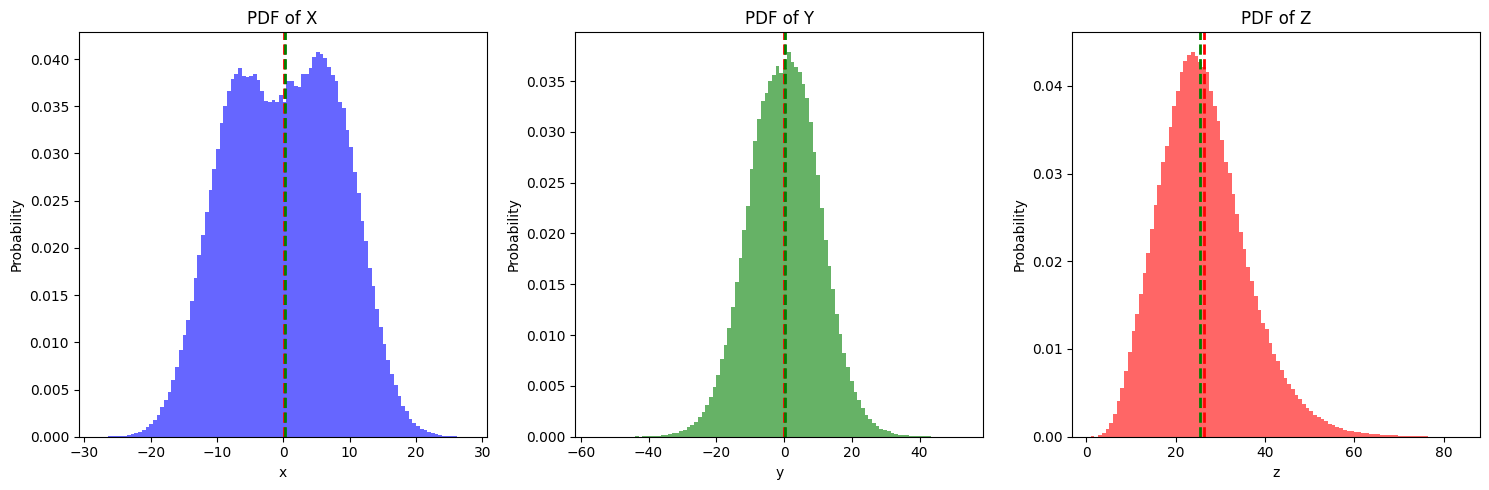

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].hist(x_values, bins=100, density=True, color='blue', alpha=0.6)
axs[0].axvline(x_mean, color='red', linestyle='dashed', linewidth=2, label='Mean')
axs[0].axvline(x_median, color='green', linestyle='dashed', linewidth=2, label='Median')
axs[0].set_title('PDF of X')
axs[0].set_xlabel('x')
axs[0].set_ylabel('Probability')

axs[1].hist(y_values, bins=100, density=True, color='green', alpha=0.6)
axs[1].axvline(y_mean, color='red', linestyle='dashed', linewidth=2, label='Mean')
axs[1].axvline(y_median, color='green', linestyle='dashed', linewidth=2, label='Median')
axs[1].set_title('PDF of Y')
axs[1].set_xlabel('y')
axs[1].set_ylabel('Probability')

axs[2].hist(z_values, bins=100, density=True, color='red', alpha=0.6)
axs[2].axvline(z_mean, color='red', linestyle='dashed', linewidth=2, label='Mean')
axs[2].axvline(z_median, color='green', linestyle='dashed', linewidth=2, label='Median')
axs[2].set_title('PDF of Z')
axs[2].set_xlabel('z')
axs[2].set_ylabel('Probability')

plt.tight_layout()
plt.show()

In [ ]:
z_quantiles = [22.5,37.9] #75th, 95th quantiles
partitions = []

def assign_region(x,y,z):
  if z < z_quantiles[0]:
    z_index = 0
  elif z < z_quantiles[1]:
    z_index = 1
  else:
    z_index = 2

  if x > 0 and y > 0:
    xy_index = 0
  elif x > 0 and y < 0:
    xy_index = 1
  elif x < 0 and y > 0:
    xy_index = 2
  elif x < 0 and y < 0:
    xy_index = 3

  return z_index*3 + xy_index

for x,y,z in zip(x_values,y_values,z_values):
  partitions.append(assign_region(x,y,z))

In [ ]:
n_partitions = 12
T_mat = np.zeros((n_partitions,n_partitions))
holding_times = np.zeros(n_partitions)
state_counts = np.zeros(n_partitions)

current_state = partitions[0]
time_in_state = 0.0
for i in range(1,len(partitions)):
  next_state = partitions[i]
  time_in_state += dt
  if next_state != current_state:
    T_mat[current_state,next_state] += 1
    holding_times[current_state] += time_in_state
    state_counts[current_state] += 1
    current_state = next_state
    time_in_state = 0.0

for i in range(n_partitions):
  if state_counts[i] > 0:
    holding_times[i] /= state_counts[i]
  else:
    holding_times[i] /= 1 #holding_times = 1

for j in range(n_partitions):
  col_sums = np.sum(T_mat[:,j])
  for i in range(n_partitions):
    if col_sums > 0:
      T_mat[i,j] = T_mat[i,j]/col_sums
  T_mat[j,j] = -np.sum(T_mat[:,j])

HT = np.diag(holding_times)
Q = np.dot(T_mat,HT)

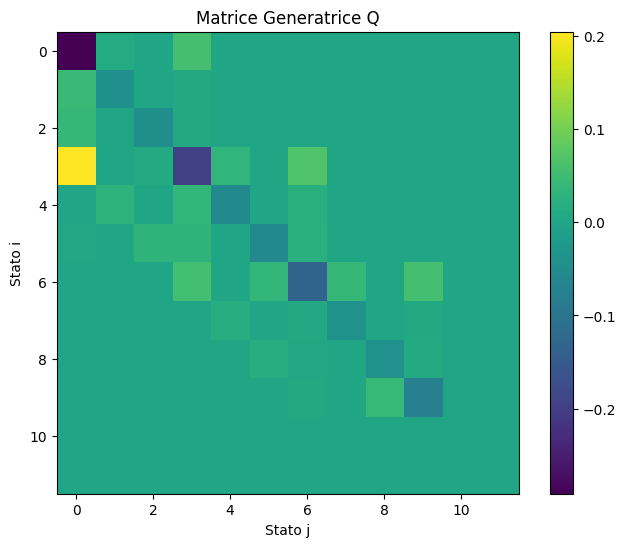

In [ ]:
plt.figure(figsize=(8, 6))
plt.imshow(Q, cmap='viridis', interpolation='nearest')
plt.colorbar()
plt.title('Matrice Generatrice Q')
plt.xlabel('Stato j')
plt.ylabel('Stato i')
plt.show()

In [ ]:
macrostates = []
#macrostates = [0,1,1,0,2]

def assign_macrostate(z):
  if z < z_quantiles[0]:
    return 0
  elif z < z_quantiles[1]:
    return 1
  else:
    return 2

for z in z_values:
  macrostates.append(assign_macrostate(z))

n_macrostates = 3
transition_matrix = np.zeros((n_macrostates,n_macrostates))
holding_times_macro = np.zeros(n_macrostates)
state_counts_macro = np.zeros(n_macrostates)

current_state_macro = macrostates[0]
time_in_state_macro = 0.0

for i in range(1, len(macrostates)):
  next_state_macro = macrostates[i]
  time_in_state_macro += dt
  if next_state_macro != current_state_macro:
    transition_matrix[current_state_macro, next_state_macro] += 1
    holding_times_macro[current_state_macro] += time_in_state_macro
    state_counts_macro[current_state_macro] += 1
    current_state_macro = next_state_macro
    time_in_state_macro = 0.0

for i in range(n_macrostates):
  if state_counts_macro[i] > 0:
    holding_times_macro[i] /= state_counts_macro[i]
  else:
    holding_times_macro[i] /= 1

In [ ]:
macrostates_table = pd.DataFrame({'Mean holding time': holding_times_macro})
macrostates_table.index = ['Macrostate A', 'Macrostato B', 'Macrostato C']
macrostates_table

,Mean holding time
Macrostate A,0.333255
Macrostato B,0.260509
Macrostato C,0.142237
